In [1]:
from walidacja_funkcji import *
import torch
import torch.nn as nn
import torch.optim as optim

In [18]:
def reinit_model(model):
    """Reinicjalizuje wagi modelu"""
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

def fast_kl_jsd_2d(real_data, fake_data, bins=50):
    all_data = np.vstack([real_data, fake_data])
    range_2d = [(all_data[:, i].min(), all_data[:, i].max()) for i in range(2)]
    
    # Histogramy w jednej operacji
    P, _ = np.histogramdd(real_data, bins=bins, range=range_2d, density=True)
    Q, _ = np.histogramdd(fake_data, bins=bins, range=range_2d, density=True)
    
    # Normalizacja do prawdopodobieństw
    P = P / P.sum()
    Q = Q / Q.sum()
    
    # Epsilon dla stabilności numerycznej
    epsilon = 1e-8
    P += epsilon
    Q += epsilon
    
    # KL divergence: KL(Q||P) - fake vs real
    kl_divergence = np.sum(Q * np.log(Q / P))
    
    # JSD: 0.5 * [KL(P||M) + KL(Q||M)], gdzie M = (P+Q)/2
    M = (P + Q) / 2 + epsilon
    
    kl_pm = np.sum(P * np.log(P / M))
    kl_qm = np.sum(Q * np.log(Q / M))
    jsd = 0.5 * (kl_pm + kl_qm)
    
    return kl_divergence, jsd

In [21]:
"""
    Generator z szumu bedzie dawac x i y - ale czy ja powinienem mu przeslac informacje o zakresie w jakim ma generowac x ?
"""

class Generator(nn.Module):
    def __init__(self, layers: list, lr: float = 5e-4, BATCH_SIZE: int = 64):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.RMSprop(self.parameters(), lr)
        self.loss = nn.MSELoss()
        self = self.to('cuda')
        var_x, var_y = 0, 0
        noise = torch.randn(size=(BATCH_SIZE, 128)).cuda()

        while var_x < 1.5e-1 or var_y < 1.5e-1:
            output = self.layers(noise).detach().cpu().numpy()
            var_x = np.var(output[:, 0])
            var_y = np.var(output[:, 1])
        
            for layer in self.modules():
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
        print(f'{var_x=}, {var_y=}')

In [22]:
"""
    Dyskriminator tak jak zwykle bierze input i zwraca czy prawdziwy czy nie
"""

class Discriminator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.SGD(self.parameters(), lr)
        self.loss = nn.BCEWithLogitsLoss()
        self = self.to('cuda')

    def training_step(self, true_data, fake_data, steps):
        for _ in range(steps):
            self.optim.zero_grad()
            y_true = self.layers(true_data)
            loss_true = self.loss(y_true, torch.ones_like(y_true).cuda())

            y_fake = self.layers(fake_data)
            loss_fake = self.loss(y_fake, torch.zeros_like(y_true).cuda())
            

            loss = loss_true + loss_fake
            loss.backward()
            self.optim.step()
        
        return loss

In [ ]:
def plot_basic_stats(var_x, var_y, generator_losses, discriminator_losses, KL, JSD, kl_jsd_steps_to_calculate):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18, 18))

    # Wykres 1: Straty
    ax1.set_title(rf'Straty modeli dla $lr_{{gen}}$ = {generator.optim.param_groups[0]['lr'] :.2e}, $lr_{{dyskryminator}}$ = {discriminator.optim.param_groups[0]['lr'] :.2e}')
    ax1.plot(discriminator_losses, label='dyskryminator - BCE')
    ax1.plot(generator_losses, label='generator - MSE')
    ax1.legend()
    ax1.set_xlabel('epoka')
    ax1.set_ylabel('strata')

    # Wykres 2: Powierzchnia decyzyjna
    x_range = np.linspace(0, 25, num=1_000)
    y_range = np.linspace(0, 8, num=1_000)
    X, Y = np.meshgrid(x_range, y_range)
    mapa = torch.FloatTensor(np.column_stack([X.flatten(), Y.flatten()])).cuda()
    discriminator_assessment = discriminator.layers(mapa).cpu().detach().numpy().reshape(x_range.shape[0], y_range.shape[0])
    ax2.set_title('Powierzchnia decyzyjna dysriminatora\n0 - falszywa probka, 1 - prawdziwa probka')
    contour = ax2.contourf(X, Y, discriminator_assessment, levels=250)
    plt.colorbar(contour, ax=ax2)

    # Wykres 3: Próbki generatora
    noise = torch.randn(size=(100 * BATCH_SIZE, 128)).cuda()
    x, y = [], []
    output = generator.layers(noise).cpu().detach().numpy().reshape(-1, 2)
    x.extend(output[:, 0])
    y.extend(output[:, 1])
    x = np.array(x)
    y = np.array(y)
    x_krzywa = np.linspace(np.min(x), np.max(x), num=x.size)
    y_krzywa = greisen(x_krzywa)
    
    ax3.set_title('Probki jakie wyrzuca generator dla szumu\nPowinien byc to rozklad greisena')
    ax3.scatter(x, y, s=0.1, label='Co generator wyrzucil')
    ax3.scatter(x_krzywa, y_krzywa, s=0.1, label='Krzywa teoretyczna')
    ax3.legend()
    ax3.set_xlabel('t z rozkladu greisena')
    ax3.set_ylabel('N z rozkladu greisena')

    # Wykres 4 wariancje
    ax4.set_title(r'$log_{10}$ z wariancji wyrzucanych przez generator i dyskryminator\n(Chce zobaczyc jak daleko od mode collapse\'a jest)')
    ax4.plot(np.log10(var_x), label='x')
    ax4.plot(np.log10(var_y), label='y')
    ax4.legend()
    ax4.set_xlabel('epoka')
    ax4.set_ylabel(r'$log_{10}$(sum(wspolrzedna))')

    # Wykres 5 czestosci
    x_greisen_random, _ = metropolis_hastings_probing(greisen, x.size)

    ax5.set_title('Porownanie czestosci wystepowania wspolrzednych x dla GANa i rozkladu greisena')
    ax5.hist(x_greisen_random, bins=80, label='Greisen')
    ax5.hist(x, bins=80, label='GAN')
    ax5.legend()
    ax5.set_xlabel('Wspolrzedna x')
    ax5.set_ylabel('Ilosc losowych probek dla danej wspolrzednej x')

    ax6.set_title('Kullbak-Leibner (KL) i Jensen-Shannon divergence (JSD) dla generatora obv.')
    ax6.plot(np.arange(JSD.size) * kl_jsd_steps_to_calculate, np.log10(JSD), label='JSD')
    ax6.plot(np.arange(KL.size) * kl_jsd_steps_to_calculate, np.log10(KL), label='KL')
    ax6.legend()
    ax6.set_xlabel('Epoka')
    ax6.set_ylabel(r'$log_{10}$(Wartosc bledu)')

    plt.tight_layout()
    plt.savefig('./Wykresy/GAN/podsumowanie.jpg')

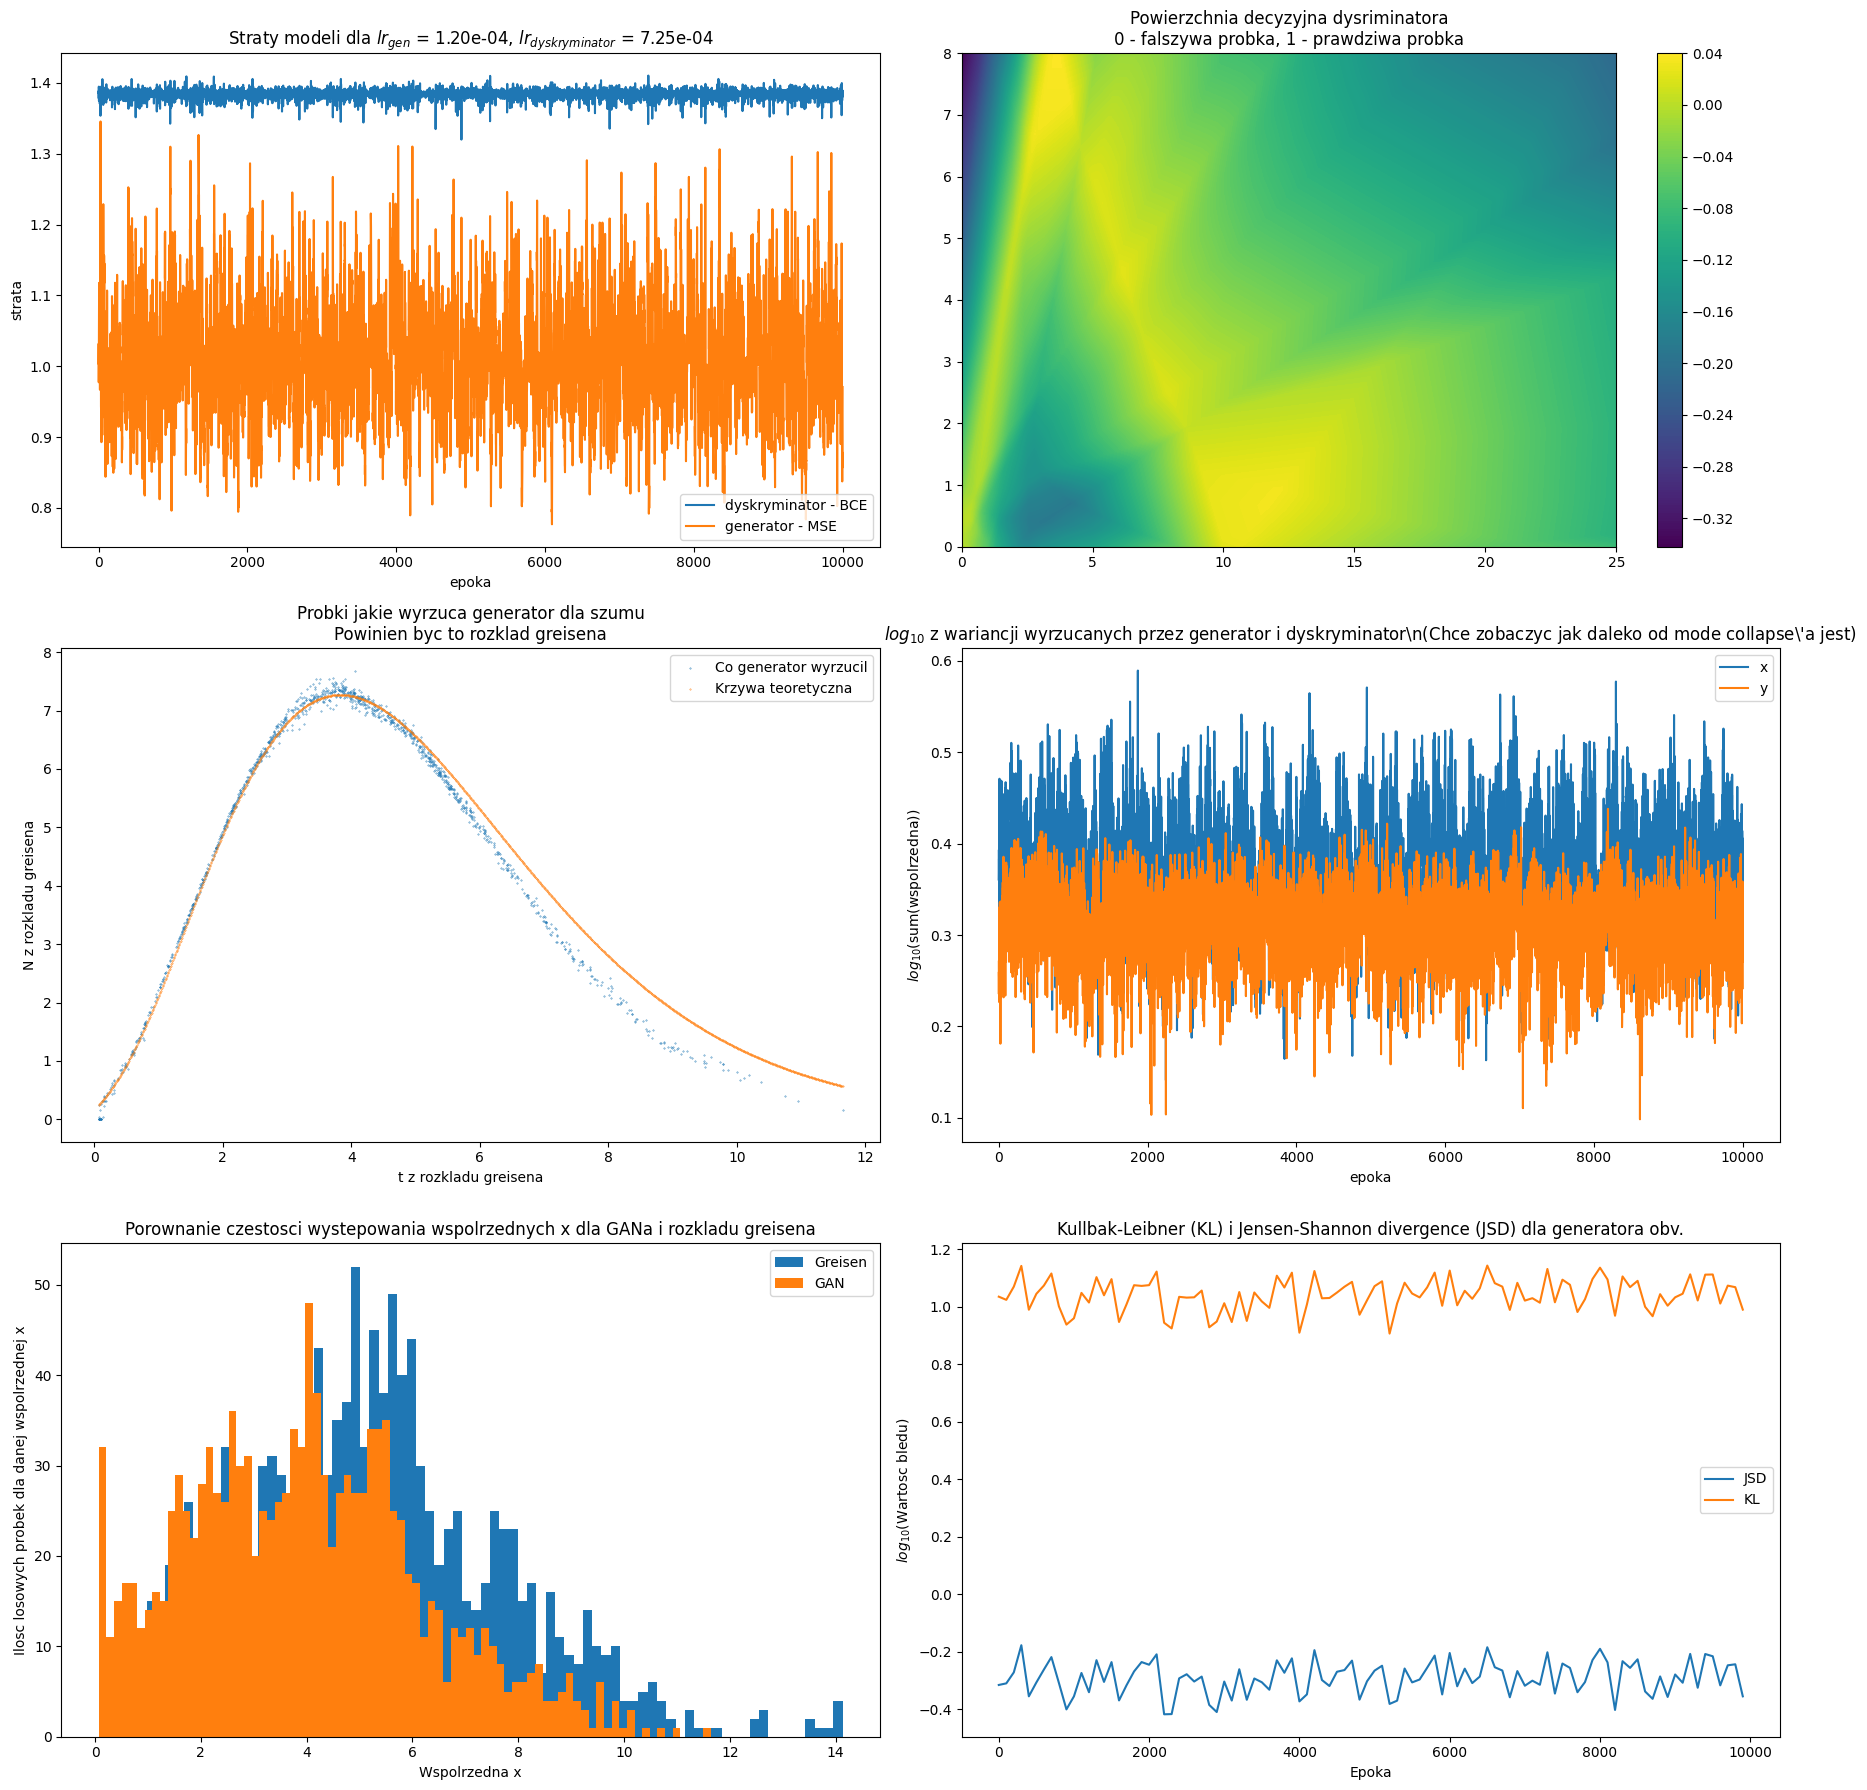

In [37]:
# set_seed(69)

# generator_layers = [ # bez konwolucji poki co, potem sie doda batchNorm i funkcje aktywacji
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, 32),
#     nn.ReLU(),
#     nn.Linear(32, 16),
#     nn.ReLU(),
#     nn.Linear(16, 8),
#     nn.ReLU(),
#     nn.Linear(8, 4),
#     nn.ReLU(),
#     nn.Linear(4, 2),
#     nn.ReLU()
# ]
# generator = Generator(generator_layers, 1.2e-4) #! Na e-4 juz sa za male lr-y nieco

# discriminator_layers = [ #! Nie dodawaj sigmoida to sie nie sprawdza
#     nn.Linear(2, 64),
#     nn.LeakyReLU(0.2),
#     nn.Linear(64, 32),
#     nn.LeakyReLU(0.2),
#     nn.Linear(32, 16),
#     nn.LeakyReLU(0.2),
#     nn.Linear(16, 8),
#     nn.LeakyReLU(0.2),
#     nn.Linear(8, 2),
#     nn.LeakyReLU(0.2),
#     nn.Linear(2, 1)
# ]
# discriminator = Discriminator(discriminator_layers, 0.725e-3)

EPOCHS = 10_000
BATCH_SIZE = 64

kl_jsd_steps_to_calculate = 100

var_x = np.zeros(EPOCHS)
var_y = np.zeros(EPOCHS)
generator_losses = np.zeros(EPOCHS)
discriminator_losses = np.zeros(EPOCHS)
KL = np.zeros(EPOCHS // kl_jsd_steps_to_calculate)
JSD = np.zeros(EPOCHS // kl_jsd_steps_to_calculate)

generator.train()
discriminator.train()

epoch = 0

while epoch < EPOCHS:
    xs, ys = metropolis_hastings_probing(greisen, length=BATCH_SIZE)
    true_data = torch.FloatTensor(np.vstack([xs, ys]).T).cuda()
    
    noise = torch.randn(size=(BATCH_SIZE, 128)).cuda()
    fake_data = generator.layers(noise).detach()
    
    var_x[epoch] = np.std( fake_data.cpu().detach().numpy()[:, 0] )
    var_y[epoch] = np.std( fake_data.cpu().detach().numpy()[:, 1] )

    discriminator_loss = discriminator.training_step(true_data, fake_data, 5)
    
    # statystyki KL i JSD
    if epoch % kl_jsd_steps_to_calculate:
        index_adjusted = epoch // kl_jsd_steps_to_calculate
        KL[index_adjusted], JSD[index_adjusted] = fast_kl_jsd_2d(true_data.cpu().detach().numpy(), fake_data.cpu().numpy())

    # trenowanie generatora
    generator.zero_grad()
    fake_data = generator.layers(noise)
    fake_labels = discriminator.layers(fake_data)
    generator_loss = generator.loss(fake_labels, torch.ones_like(fake_labels).cuda())
    generator_loss.backward()
    generator.optim.step()

    generator_losses[epoch] = generator_loss.item()
    discriminator_losses[epoch] = discriminator_loss.item()


    if np.isclose(var_x[epoch], 0.0) or np.isclose(var_y[epoch], 0.0):
        print(f'Mode collapse dla iteracji {epoch}')
        reinit_model(discriminator)
        reinit_model(generator)
        epoch = 0 # od nowa sie zaczyna uczyc
        plot_basic_stats(var_x, var_y, generator_losses, discriminator_losses, KL, JSD, kl_jsd_steps_to_calculate)
        continue
    
    epoch += 1
    
plot_basic_stats(var_x, var_y, generator_losses, discriminator_losses, KL, JSD, kl_jsd_steps_to_calculate)

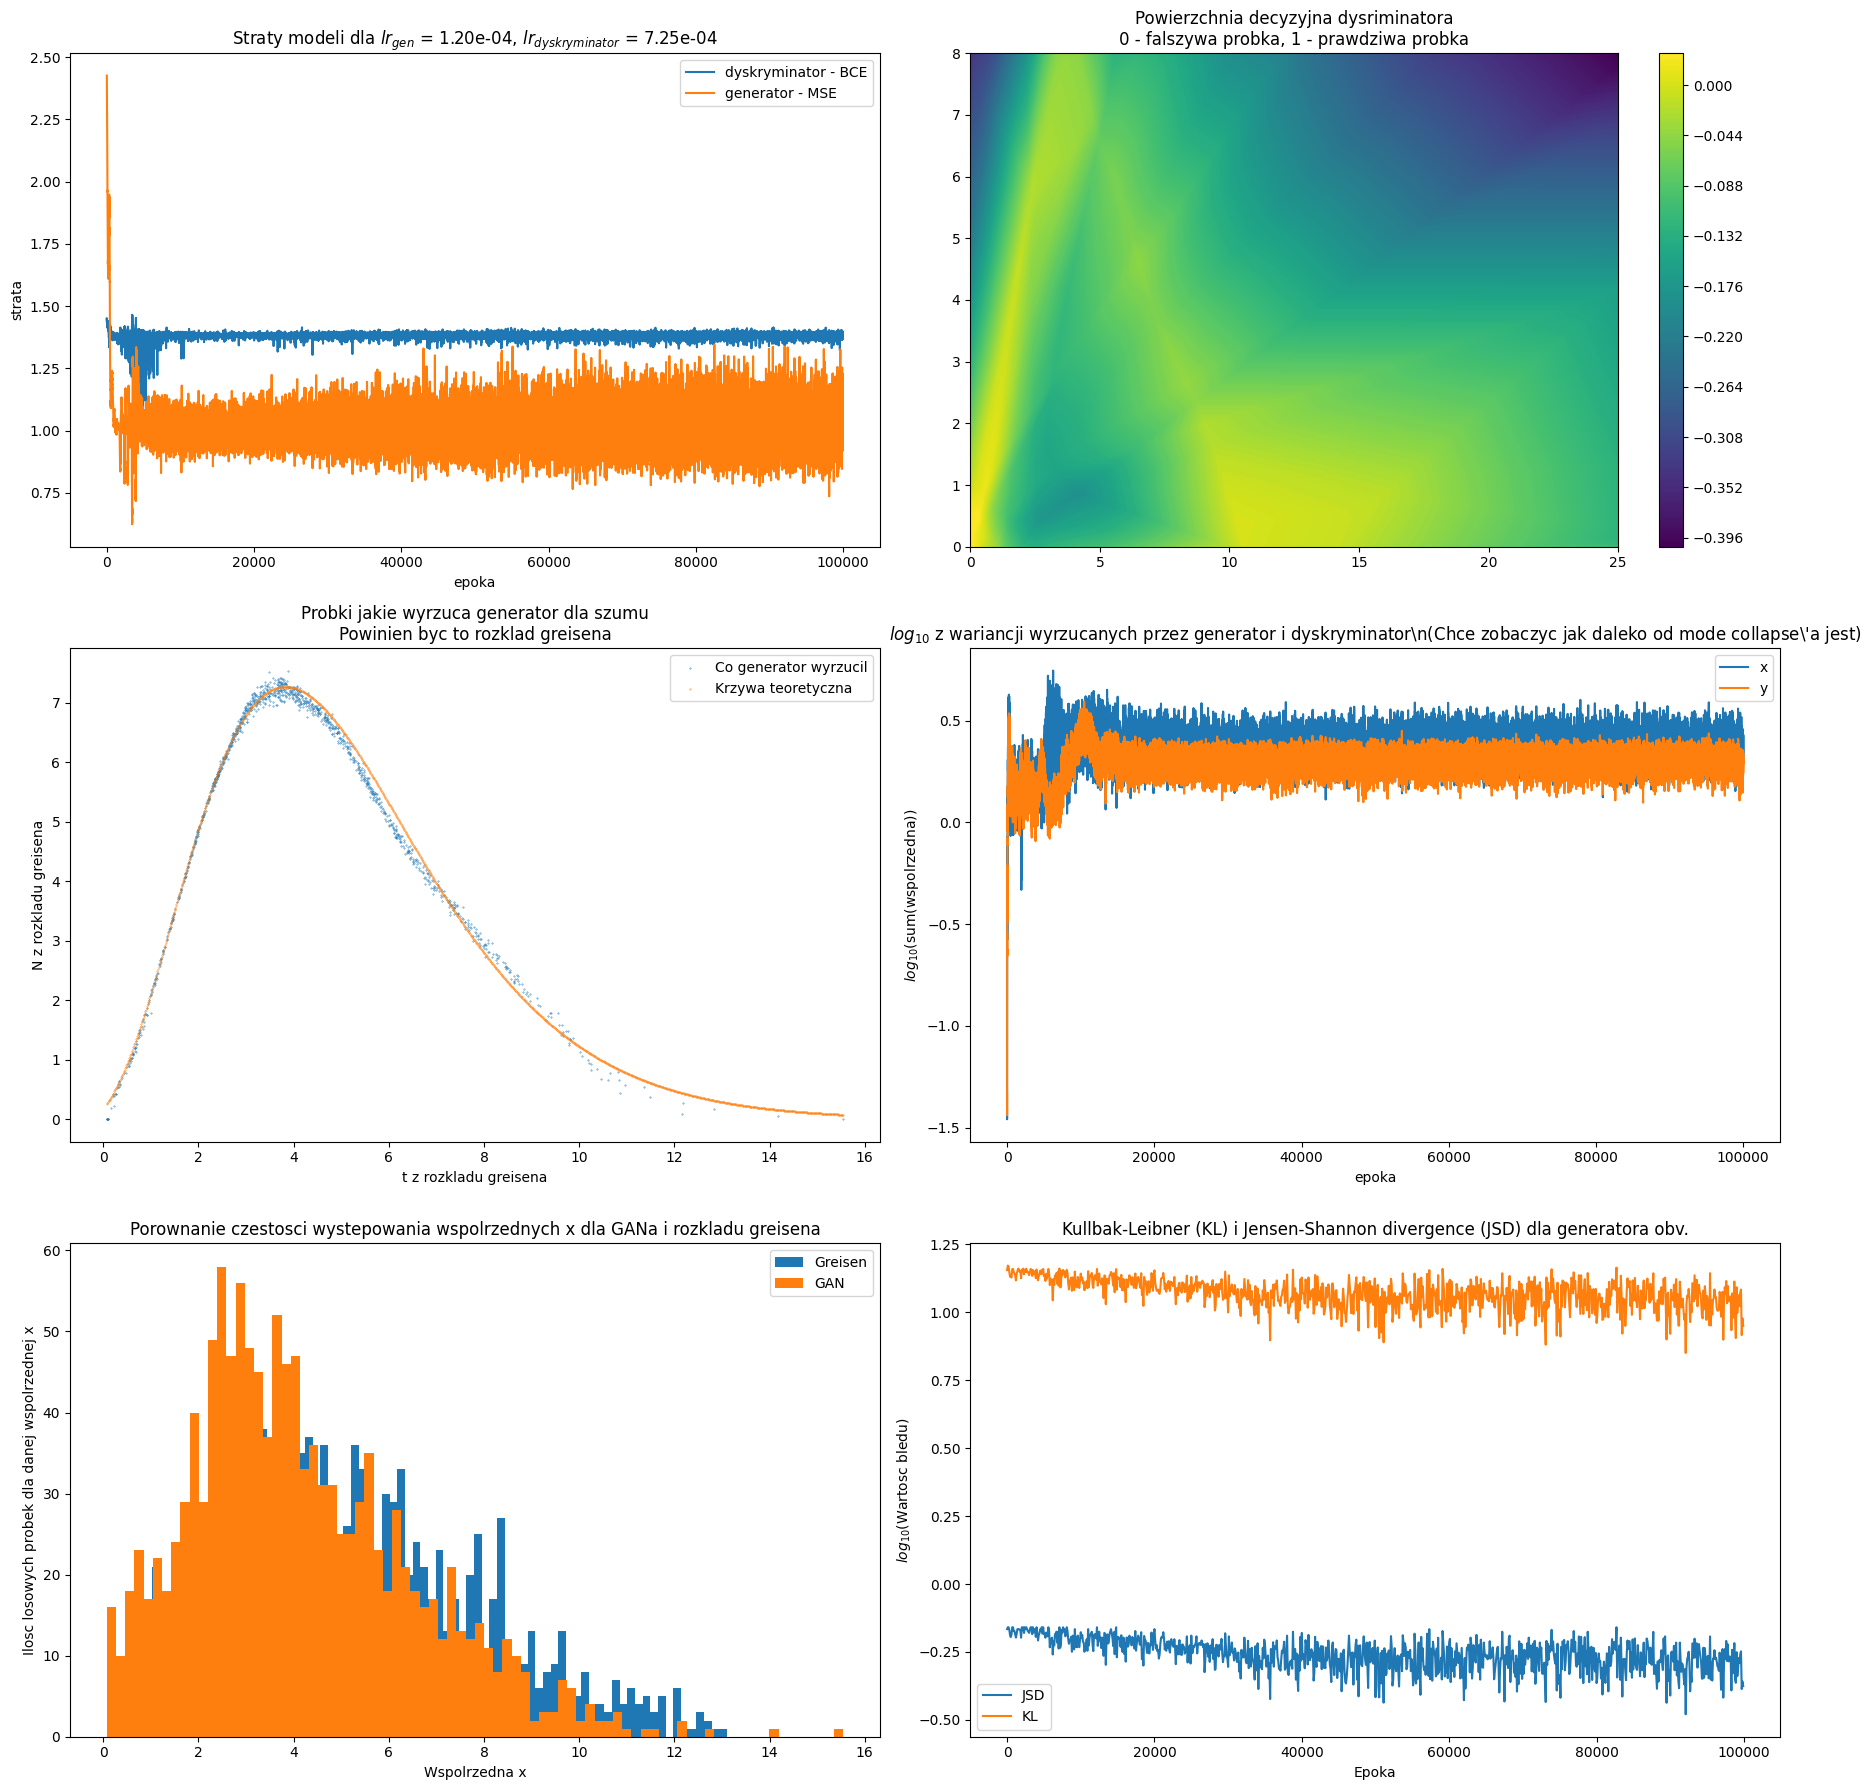

In [35]:
plot_basic_stats(var_x, var_y, generator_losses, discriminator_losses, KL, JSD, kl_jsd_steps_to_calculate)

In [36]:
torch.save(discriminator.state_dict(), "best_discriminator_so_far.pth")
torch.save(generator.state_dict(), 'best_generator_so_far.pth')